In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


In [2]:
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, precision_recall_curve, 
                             average_precision_score, f1_score, precision_score,
                             recall_score, confusion_matrix, classification_report)
from sklearn.svm import OneClassSVM
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
files = glob.glob('/kaggle/input/**/creditcard*.csv', recursive=True)
if len(files)==0: raise FileNotFoundError("Upload 'Credit Card Fraud Detection' dataset")
data_path = files[0]
df = pd.read_csv(data_path)
print("Shape:", df.shape)
display(df.head())
print(df['Class'].value_counts())


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
X = df.drop('Class', axis=1)
y = df['Class'].values

scaler = StandardScaler()
X[['Time','Amount']] = scaler.fit_transform(X[['Time','Amount']])
X = X.values.astype(np.float32)
y = y.astype(int)


In [5]:
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=SEED)

X_train_norm = X_train[y_train==0]  # Only normal for AE training
print("Train (normals) shape:", X_train_norm.shape)
print("Val shape:", X_val.shape, "Test shape:", X_test.shape)


Train (normals) shape: (170588, 30)
Val shape: (56962, 30) Test shape: (56962, 30)


In [6]:
BATCH_SIZE = 1024
train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_norm)),
                          batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val)),
                        batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test)),
                         batch_size=BATCH_SIZE, shuffle=False)
input_dim = X.shape[1]


In [7]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim)
        )
    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

model = DenoisingAutoencoder(input_dim=input_dim, latent_dim=16).to(device)
print(model)


DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=30, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=30, bias=True)
  )
)


In [8]:
def train_denoising_ae(model, train_loader, val_normal, epochs=100, lr=1e-3, 
                       noise_factor=0.05, patience=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                           factor=0.5, patience=5, verbose=True)
    best_val_loss = np.inf
    epochs_no_improve = 0
    best_state = None

    for epoch in range(1, epochs+1):
        model.train()
        train_losses = []
        for batch in train_loader:
            x = batch[0].to(device)
            x_noisy = x + noise_factor*torch.randn_like(x)
            x_hat = model(x_noisy)
            loss = criterion(x_hat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        avg_train_loss = np.mean(train_losses)

        model.eval()
        with torch.no_grad():
            x_val = val_normal.to(device)
            x_val_hat = model(x_val)
            val_loss = criterion(x_val_hat, x_val).item()

        scheduler.step(val_loss)
        print(f"Epoch {epoch:02d} | Train loss {avg_train_loss:.6f} | Val loss {val_loss:.6f}")

        if val_loss < best_val_loss - 1e-6:
            best_val_loss = val_loss
            best_state = {k: v.cpu() for k,v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping.")
                break

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

val_normal_tensor = torch.from_numpy(X_val[y_val==0]).float()
model = train_denoising_ae(model, train_loader, val_normal_tensor, epochs=100, lr=1e-3, patience=10)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 01 | Train loss 0.671358 | Val loss 0.414855
Epoch 02 | Train loss 0.291612 | Val loss 0.221240
Epoch 03 | Train loss 0.188867 | Val loss 0.173469
Epoch 04 | Train loss 0.150512 | Val loss 0.140241
Epoch 05 | Train loss 0.124099 | Val loss 0.117494
Epoch 06 | Train loss 0.105777 | Val loss 0.104425
Epoch 07 | Train loss 0.093325 | Val loss 0.090701
Epoch 08 | Train loss 0.083361 | Val loss 0.083714
Epoch 09 | Train loss 0.075938 | Val loss 0.074788
Epoch 10 | Train loss 0.069958 | Val loss 0.069554
Epoch 11 | Train loss 0.064736 | Val loss 0.064053
Epoch 12 | Train loss 0.059815 | Val loss 0.058235
Epoch 13 | Train loss 0.056031 | Val loss 0.053293
Epoch 14 | Train loss 0.052215 | Val loss 0.049497
Epoch 15 | Train loss 0.049019 | Val loss 0.046617
Epoch 16 | Train loss 0.046943 | Val loss 0.046772
Epoch 17 | Train loss 0.045324 | Val loss 0.043333
Epoch 18 | Train loss 0.043704 | Val loss 0.043426
Epoch 19 | Train loss 0.042307 | Val loss 0.041201
Epoch 20 | Train loss 0.040943 

In [9]:
def reconstruction_errors(model, dataloader):
    model.eval()
    errors, labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            if len(batch)==2: x, yb = batch
            else: x = batch[0]; yb = None
            x = x.to(device).float()
            x_hat = model(x)
            se = torch.mean((x - x_hat)**2, dim=1).cpu().numpy()
            errors.append(se)
            if yb is not None: labels.append(yb.numpy())
    errors = np.concatenate(errors)
    labels = np.concatenate(labels) if len(labels) else None
    return errors, labels

val_errors, val_labels = reconstruction_errors(model, val_loader)
test_errors, test_labels = reconstruction_errors(model, test_loader)


In [10]:
# # Cell 9 — Threshold selection using PR curve (choose target recall)
# precision, recall, thresholds = precision_recall_curve(val_labels, val_errors)
# desired_recall = 0.80
# idx = np.argmin(np.abs(recall - desired_recall))
# threshold = thresholds[idx]
# print(f"Threshold for {desired_recall*100:.0f}% recall: {threshold:.6e}")
# from sklearn.metrics import f1_score

# best_f1, best_thresh = 0, 0
# for t in np.linspace(min(val_errors), max(val_errors), 200):
#     preds = (val_errors >= t).astype(int)
#     f1 = f1_score(val_labels, preds)
#     if f1 > best_f1:
#         best_f1, best_thresh = f1, t
# print("Best threshold:", best_thresh, "F1:", best_f1)
from sklearn.metrics import f1_score

best_f1, best_thresh = 0, 0
for t in np.linspace(min(val_errors), max(val_errors), 200):
    preds = (val_errors >= t).astype(int)
    f1 = f1_score(val_labels, preds, zero_division=0)
    if f1 > best_f1:
        best_f1, best_thresh = f1, t

threshold = best_thresh
print(f"Best threshold: {threshold:.6e}, with F1: {best_f1:.4f}")


Best threshold: 4.962303e-01, with F1: 0.5069


In [11]:
test_preds = (test_errors >= threshold).astype(int)
roc = roc_auc_score(test_labels, test_errors)
pr = average_precision_score(test_labels, test_errors)
prec_t = precision_score(test_labels, test_preds, zero_division=0)
rec_t = recall_score(test_labels, test_preds, zero_division=0)
f1_t = f1_score(test_labels, test_preds, zero_division=0)
cm = confusion_matrix(test_labels, test_preds)
print(f"Test ROC-AUC: {roc:.4f}, PR-AUC: {pr:.4f}")
print(f"Precision: {prec_t:.4f}, Recall: {rec_t:.4f}, F1: {f1_t:.4f}")
print("Confusion matrix:\n", cm)
print(classification_report(test_labels, test_preds, digits=4, zero_division=0))


Test ROC-AUC: 0.9655, PR-AUC: 0.4678
Precision: 0.3801, Recall: 0.6633, F1: 0.4833
Confusion matrix:
 [[56758   106]
 [   33    65]]
              precision    recall  f1-score   support

           0     0.9994    0.9981    0.9988     56864
           1     0.3801    0.6633    0.4833        98

    accuracy                         0.9976     56962
   macro avg     0.6898    0.8307    0.7410     56962
weighted avg     0.9984    0.9976    0.9979     56962



In [ ]:
model.eval()
with torch.no_grad():
    latent_train = model.encoder(torch.from_numpy(X_train_norm).to(device)).cpu().numpy()
    latent_test = model.encoder(torch.from_numpy(X_test).to(device)).cpu().numpy()

ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
ocsvm.fit(latent_train)
svm_preds = ocsvm.predict(latent_test)
svm_preds = np.where(svm_preds==-1,1,0)

roc_svm = roc_auc_score(test_labels, svm_preds)
pr_svm = average_precision_score(test_labels, svm_preds)
print(f"OCSVM on latent space - ROC-AUC: {roc_svm:.4f}, PR-AUC: {pr_svm:.4f}")


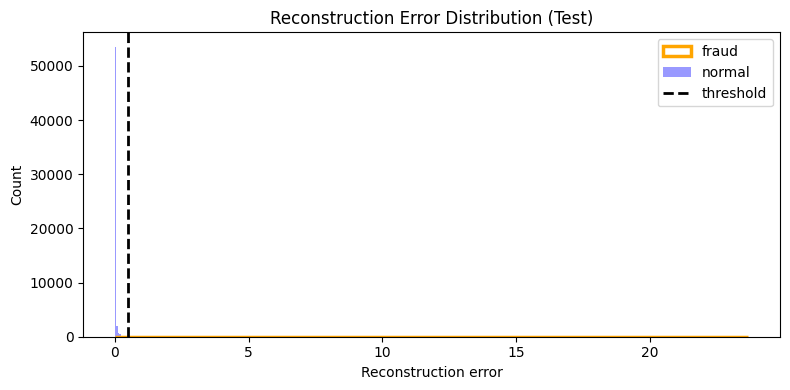

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))

plt.hist(
    test_errors[test_labels==1],
    bins=50,
    histtype='step',      
    linewidth=2.5,
    color='orange',
    label='fraud'
)

# draw normal on top (filled but semi-transparent)
plt.hist(
    test_errors[test_labels==0],
    bins=50,
    alpha=0.4,
    color='blue',
    label='normal'
)

# draw threshold line
plt.axvline(threshold, color='k', linestyle='--', linewidth=2, label='threshold')

plt.title("Reconstruction Error Distribution (Test)")
plt.xlabel("Reconstruction error")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()
